In [1]:
import torch
import torch.nn as nn
import math
from torchviz import make_dot

# Сеть с множеством выходов 

Если сеть имеет множество выходов, то backward по их сумме эквивалентен backward-у по каждой из них 

## Пример 

In [2]:
criterion = nn.MSELoss()

In [7]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
    
    def forward(self, x):
        a = torch.sin(x)
        return a

In [8]:
model = TinyModel()

In [9]:
def get_losses(input):
    torch.manual_seed(89)
    loss1 = model(input)
    return loss1.mean()

### Разработка модели

In [10]:
input = torch.linspace(0., 2. * math.pi, steps=24, requires_grad=True)

In [11]:
loss1 = get_losses(input)

In [12]:
loss1.backward()

In [13]:
print(input.grad)

tensor([ 0.0417,  0.0401,  0.0356,  0.0284,  0.0192,  0.0085, -0.0028, -0.0140,
        -0.0240, -0.0323, -0.0382, -0.0413, -0.0413, -0.0382, -0.0323, -0.0240,
        -0.0140, -0.0028,  0.0085,  0.0192,  0.0284,  0.0356,  0.0401,  0.0417])


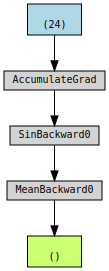

In [14]:
make_dot(loss1, params=dict(model.named_parameters()))

In [ ]:
===============================================================================

### backward по каждому выходу

In [ ]:
input, loss1, loss2, loss3 = get_losses()

In [ ]:
loss1.backward(retain_graph=True)

In [ ]:
loss2.backward(retain_graph=True)

In [ ]:
loss3.backward()

In [ ]:
print(input.grad)

In [ ]:
make_dot(loss3, params=dict(model.named_parameters()))

### backward по сумме ошибок

In [ ]:
input, loss1, loss2, loss3 = get_losses()

In [ ]:
loss1

In [ ]:
loss = loss1+loss2+loss3
loss.backward()
print(input.grad)

# =====================

In [ ]:
input, loss1, loss2, loss3 = get_losses()

In [ ]:
loss1 += loss2+loss3

In [ ]:
loss1

In [ ]:
loss1.backward()
print(input.grad)